#### Exercise 6 (4 points): Markov Switching Autoregression Models

__Do It Yourself__. 

1. Go to Bloomberg or Yahoo Finance to download the daily commodity price of your choice from **__January 1, 2020__** until **__September 30, 2023__**. 

2. Compute its continous daily, monthly and quarterly returns. Specify a markov switching autoregression model on these 3 time series from the beginning of your sample till **__December 31, 2022__**. 

3. Next, do some forecasts over the next $3$ quarters,
$9$ months and the subsequent days (for this daily prediction, please predict $20$-step ahead forecasts and next re-estimaste your model by including the true realizations and predict again $20$-step ahead
forecasts, do it till the end of the sample). You may use *statmodels* to do it.

**Be careful, you have to figure out which SARIMA-GARCH model you should apply first on the time series before adding a Markov Switching process.**

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime
import itertools

sns.set_theme(style="darkgrid")

In [2]:
# Ticker list
ticker = "ZW=F"

# Date range
start = datetime(2020, 1, 1)
end = datetime(2023, 9, 30)

# Get data
data = pd.DataFrame(
    yf.download(ticker, start=start, end=end, interval="1d")["Adj Close"],
    columns=["Adj Close"],
)

# Rename the column to the asset name wheat
data.rename(columns={"Adj Close": "Wheat"}, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Function to compute daily / monthly / quarterly continuous returns


def compute_returns(df, freq, asset):
    if freq == "daily":
        df[freq + " returns " + asset] = df[asset].pct_change()
    elif freq == "monthly":
        df[freq + " returns " + asset] = df[asset].pct_change(21)
    elif freq == "quarterly":
        df[freq + " returns " + asset] = df[asset].pct_change(63)
    else:
        print("Invalid frequency")
    return df


# Compute daily / monthly / quarterly continuous returns
for cols in data.columns:
    for freq in ["daily", "monthly", "quarterly"]:
        data = compute_returns(data, freq, cols)

In [4]:
data = data.dropna()
data

,Wheat,daily returns Wheat,monthly returns Wheat,quarterly returns Wheat
Date,,,,
2020-04-02,541.75,-0.015448,0.038830,-0.033021
2020-04-03,549.25,0.013844,0.047687,-0.009468
2020-04-06,555.75,0.011834,0.066187,0.010455
2020-04-07,549.25,-0.011696,0.051699,-0.001817
2020-04-08,548.25,-0.001821,0.040816,-0.008141
...,...,...,...,...
2023-09-25,589.00,0.016393,-0.024834,-0.186745
2023-09-26,589.00,0.000000,-0.007164,-0.140146
2023-09-27,579.50,-0.016129,-0.014456,-0.116279


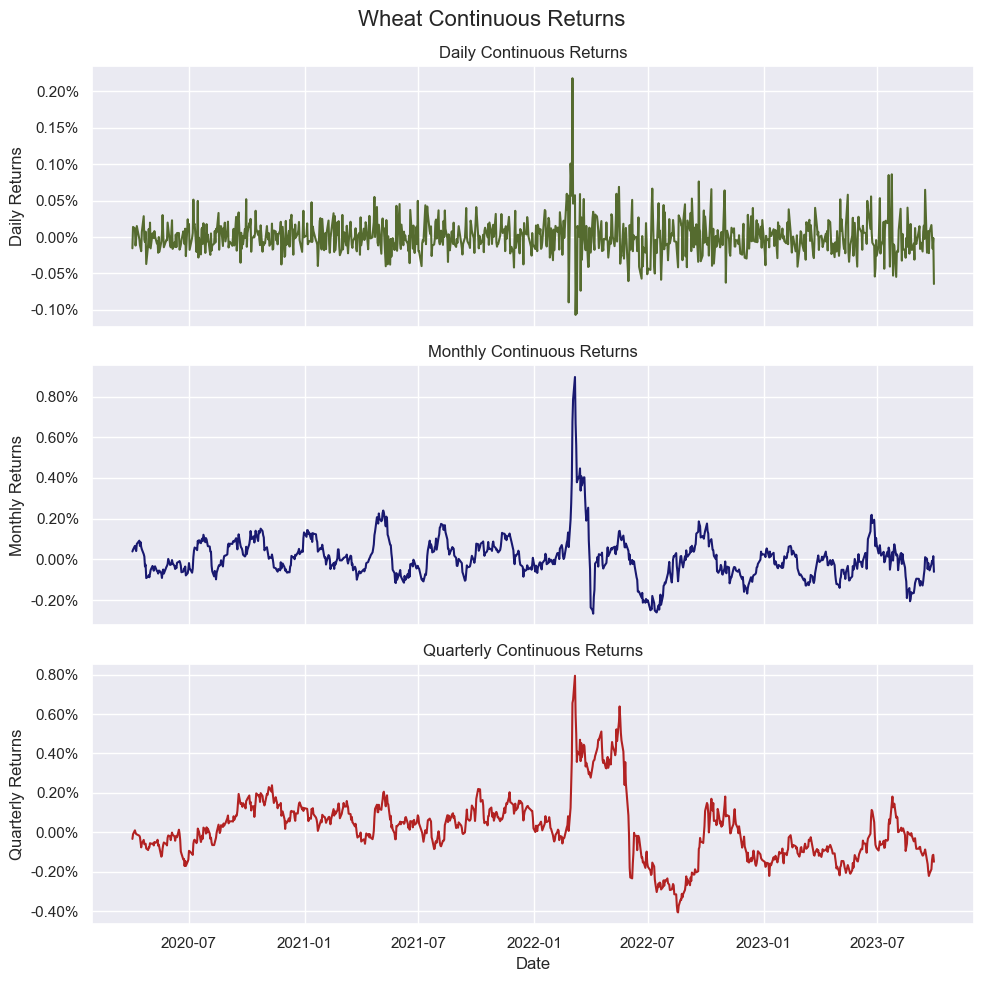

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fig.suptitle("Wheat Continuous Returns", fontsize=16)

y_formatter = lambda y, _: f"{y/100:.2%}"

for axis in ax:
    axis.yaxis.set_major_formatter(y_formatter)

# Set colors for the plot
colors = ["darkolivegreen", "midnightblue", "firebrick"]

# Plot the daily / monthly / quarterly returns of wheat prices with specified colors
ax[0].plot(data["daily returns Wheat"], color=colors[0])
ax[0].set_title("Daily Continuous Returns")

ax[1].plot(data["monthly returns Wheat"], color=colors[1])
ax[1].set_title("Monthly Continuous Returns")

ax[2].plot(data["quarterly returns Wheat"], color=colors[2])
ax[2].set_title("Quarterly Continuous Returns")

ax[2].set_xlabel("Date")

# Set the y-axis label
ax[0].set_ylabel("Daily Returns")
ax[1].set_ylabel("Monthly Returns")
ax[2].set_ylabel("Quarterly Returns")

plt.tight_layout()
plt.show()

In [23]:
# Run the Augmented Dickey-Fuller test on each of the returns series
from statsmodels.tsa.stattools import adfuller

adf_test = []
for col in data.columns[1:]:
    result = adfuller(data[col])
    adf_test.append([col, result[0], result[1]])

for result in adf_test:
    print(f"ADF Statistic for {result[0]}: {result[1]}")
    print(f"p-value: {result[2]}")
    if result[2] > 0.05:
        print("The data is not stationary")
    else:
        print("The data is stationary")
    print("\n")

ADF Statistic for daily returns Wheat: -12.205083206472395
p-value: 1.1986811904946573e-22
The data is stationary


ADF Statistic for monthly returns Wheat: -3.888991336793094
p-value: 0.0021173752625586128
The data is stationary


ADF Statistic for quarterly returns Wheat: -3.2849236555822405
p-value: 0.015565985562081965
The data is stationary




In [16]:
# Grid search for ARIMA parameters on each returns frequency
def grid_search(df, col, pdq):
    # Define the AIC variable
    aic = []
    models = []
    # Loop over the pdq list
    for param in pdq:
        try:
            # Fit the ARIMA model with the given pdq
            model = sm.tsa.ARIMA(df[col], order=param, freq="B").fit()
            # Append the aic to the aic list
            aic.append(model.aic)
            models.append(model.summary())

        except:
            continue

    # Select the model with the minimum AIC
    index_min = aic.index(min(aic))

    # Return the pdq with the minimum AIC
    return pdq[index_min], models[index_min]

In [19]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Loop over the columns of the data
for col in data.columns:
    params, summary = grid_search(data, col, pdq)
    print(f"The optimal parameters for {col} are {params}")
    print(summary)
    print("\n")

ValueError: min() arg is an empty sequence

In [11]:
# Fit the Markov switching model to the 3 time series of the wheat continuous returns using the statsmodels library
def fit_markov_model(df, col):
    # Define the model
    model = sm.tsa.MarkovAutoregression(
        df[col],
        k_regimes=2,
        order=1,
        switching_ar=False,
        switching_variance=True,
    )

    # Fit the model
    model_fit = model.fit()

    # Return the fitted model
    return model_fit


# Compute the transition matrix of the Markov switching model
def compute_transition_matrix(model_fit):
    return model_fit.expected_durations


# Compute the probability of being in the high volatility regime for each time series
def compute_high_volatility_probabilities(model_fit):
    # Return the probability of being in the high volatility regime
    return model_fit.smoothed_marginal_probabilities[0]


transition_matrix = []
high_volatility_probabilities = []
fitted_models = []

# Fit the Markov switching model to the 3 time series of the wheat continuous returns
for col in data.columns:
    model_fit = fit_markov_model(data, col)
    fitted_models.append(model_fit)
    transition_matrix.append(compute_transition_matrix(model_fit))
    high_volatility_probabilities.append(
        compute_high_volatility_probabilities(model_fit)
    )

/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has 

In [12]:
for models in fitted_models:
    print(models.summary())

                         Markov Switching Model Results                         
Dep. Variable:                    Wheat   No. Observations:                  879
Model:             MarkovAutoregression   Log Likelihood               -3672.042
Date:                  Thu, 04 Jan 2024   AIC                           7358.084
Time:                          17:16:39   BIC                           7391.535
Sample:                               0   HQIC                          7370.877
                                  - 879                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        715.4139    109.209      6.551      0.000     501.368     929.460
sigma2       147.7179      9.826    